In [1]:
# Calculate galaxy clustering data vectors using CCL, with parameters matching the DESC SRD v1
# Use the actual covariance matrix from the DESC SRD v1
# Save these using the sacc format so that they can be read in by Firecrown

In [2]:
import matplotlib.pyplot as plt 
import pyccl as ccl
import numpy as np
from scipy.ndimage import gaussian_filter
import sacc

In [3]:
#print(sacc.standard_types)

In [4]:
s = sacc.Sacc()

In [5]:
h=0.6727
cosmo = ccl.Cosmology(
    Omega_c=0.2664315,
    Omega_b=0.0491685,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
    sigma8 = 0.831,
    n_s=0.9645,
    h=h,
)

In [6]:
year = 'Y1'
if year=='Y1' or year==1 or year=='y1':
    nbin_z = 5
    z0 = 0.26
    alpha = 0.94
    sig_z = 0.03
    Ngal = 18 # Normalisation, galaxies/arcmin^2
    linear_bias = np.array([1.562362, 1.732963, 1.913252, 2.100644, 2.293210])
else:
    print('only Y1 implemented currently')

In [7]:
bin_edges = np.linspace(0.2, 1.2, nbin_z+1)
bin_low_zs = bin_edges[:-1]
bin_high_zs = bin_edges[1:]
zmids = (bin_low_zs+bin_high_zs)/2

nbin_ell = 20 
lmin = 20
lmax = 15000
ell_edges = np.geomspace(lmin, lmax, nbin_ell+1)
ell_centers = [lmin**(1-(i+0.5)/nbin_ell)*lmax**((i+0.5)/nbin_ell) for i in range(nbin_ell)]

chis = ccl.comoving_radial_distance(cosmo, 1/(1+zmids)) # Mpc
kmax = 0.3*h
lmax = kmax*chis-0.5
print(chis, lmax)

z= np.linspace(0., 3., 1001)
#redshift distribution normalized to galaxy number density -- I don't think the normalization matters
pz = (z / z0)**2. * np.exp(-(z / z0)**alpha) # Redshift distribution, p(z)
norm = Ngal/np.trapz(pz, z)
nz = norm * pz # Number density distribution

[1238.63710946 1954.66118333 2588.85137046 3150.07671375 3647.88944916] [249.46935506 393.97017341 521.95609507 635.2169816  735.68056973]


In [8]:
tracers = []
for i, zmin in enumerate(bin_low_zs):
    zmax = bin_high_zs[i]
    zmid = zmids[i]
    nz_bin = np.zeros_like(z)
    nz_bin[(z>zmin) & (z<zmax)] = nz[(z>zmin) & (z<zmax)]
    dz = z[1]-z[0]
    nz_bin = gaussian_filter(nz_bin, sig_z*(1+zmid)/dz)
    
    # galaxy clustering CCL tracer for computing mock datavector
    galaxy_tracer_bin = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz_bin), bias=(z,linear_bias[i]*np.ones(len(z))), mag_bias=None)
    tracers.append(galaxy_tracer_bin)
    
    # galaxy clustering SACC tracer for saving to file later
    s.add_tracer('NZ', "lens%d" % (i),  # Name
             quantity='galaxy_density',  # Quantity
             spin=0,  # Spin
             z=z,  # z
             nz=nz_bin)  # nz 

[    0     1     2 ... 14998 14999 15000]


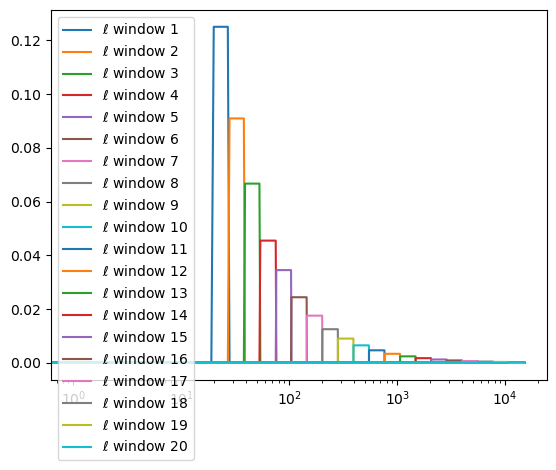

In [9]:
ell_unbinned = np.arange(0, 15001)
print(ell_unbinned)
n_ell_unbinned = len(ell_unbinned)
# window functions in ell: assume tophat
ell_windows_tophat = np.zeros([n_ell_unbinned, nbin_ell])
for i in range(nbin_ell):
    ell_windows_tophat[:,i] = (ell_unbinned>=ell_edges[i]) & (ell_unbinned<=ell_edges[i+1])
    ell_windows_tophat[:,i]/=np.sum(ell_windows_tophat[:,i])
    plt.plot(ell_unbinned, ell_windows_tophat[:,i], label=r'$\ell$ window '+str(i+1))
plt.xscale('log')
plt.legend()
plt.show()


In [10]:
# Create a SACC bandpower window object
wins = sacc.BandpowerWindow(ell_unbinned, ell_windows_tophat)

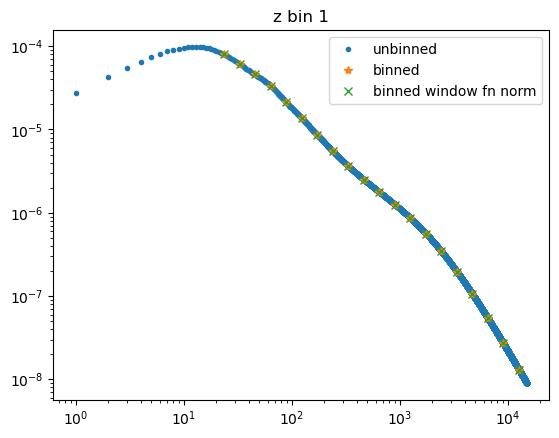

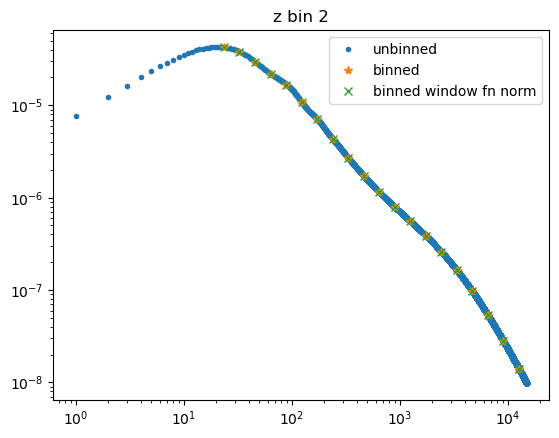

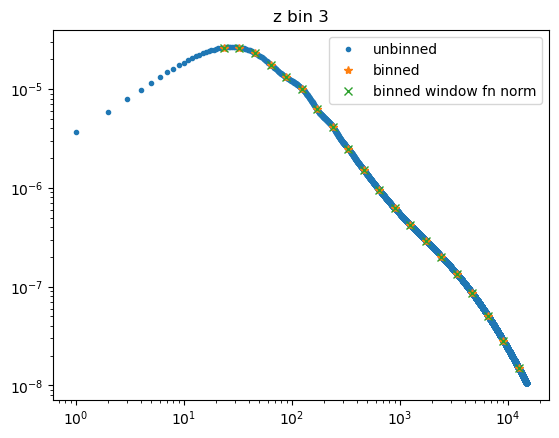

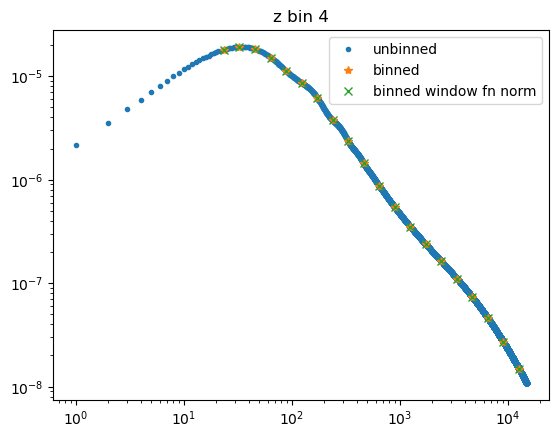

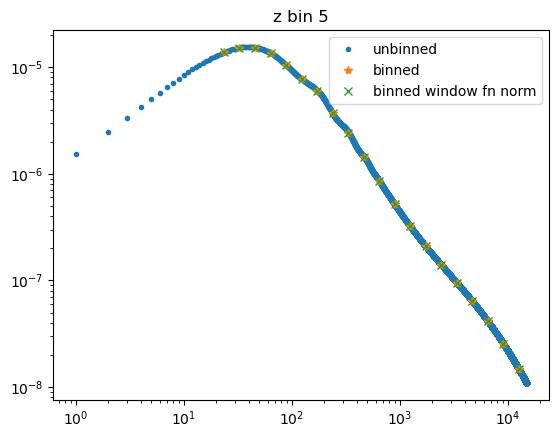

In [11]:
for i in range(nbin_z):
    cl_zbin_i = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell_unbinned)
    cl_binned = [np.mean(cl_zbin_i[(ell_unbinned>=ell_edges[j]) & (ell_unbinned<=ell_edges[j+1])]) for j in range(nbin_ell)]
    cl_binned_win = [np.sum(cl_zbin_i*ell_windows_tophat[:,j])for j in range(nbin_ell)]
    # cosmolike convention is that for scales that we are going to cut, the cls are set to 0
    # what is best practice for implementing scale cuts in sacc format?
    plt.loglog(ell_unbinned, cl_zbin_i, '.', label='unbinned')
    plt.loglog(ell_centers, cl_binned, '*', label='binned')
    plt.loglog(ell_centers, cl_binned_win, 'x', label='binned window fn norm')
    plt.legend()
    plt.title('z bin '+str(i+1))
    plt.show()
    
    # GC-GC
    s.add_ell_cl('galaxy_density_cl',  # Data type
     "lens%d" % (i),  # 1st tracer's name
     "lens%d" % (i),  # 2nd tracer's name
     ell_centers,  # Effective multipole
     cl_binned,  # Power spectrum values
     window=wins,  # Bandpower windows
    )

In [12]:
# read in covariance matrix from DESC SRD CosmoLike, select galaxy clustering bits
# covmat
cov = np.loadtxt('../datafiles/cosmolike_srd/cov/Y1_pos_pos_cov_unmasked.txt')
mask = np.abs(cov)>1e-15

In [13]:
s.add_covariance(cov) # deal with mask?

In [14]:
s.save_fits("lsst_y1_desc_srd_sacc.fits", overwrite=True)